<>:158: SyntaxWarning: invalid escape sequence '\D'
<>:158: SyntaxWarning: invalid escape sequence '\D'
/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1997/2734569875.py:158: SyntaxWarning: invalid escape sequence '\D'
  label=f'$\Delta T$ = {delta_T:.0f}K')


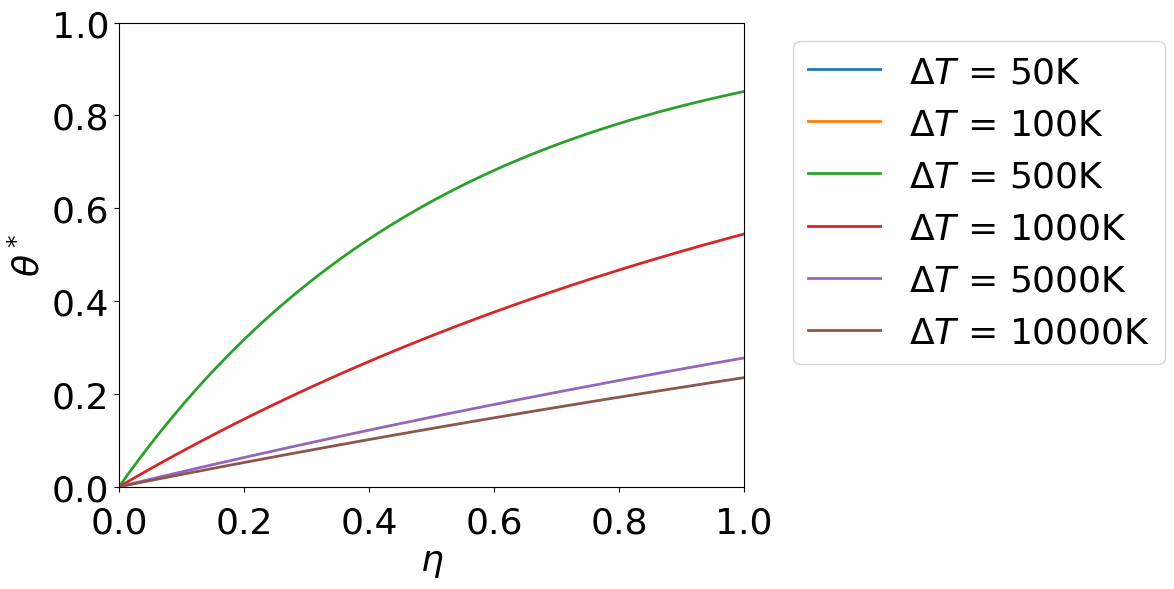

/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1997/2734569875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)


\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
$\Delta T$ (K) & $v_e$ & $\theta^*(\eta=1)$ & $T_f$ ($^\circ$C) & Ra & Ri & $\phi$ \\
\hline
50 & nan & nan & nan & 2.23e+06 & 2.58e+02 & 5.4496 \\
\hline
100 & nan & nan & nan & 3.75e+06 & 3.65e+02 & 2.7248 \\
\hline
500 & 2.62 & 0.8514 & 445.68 & 1.25e+07 & 8.17e+02 & 0.5450 \\
\hline
1000 & 6.36 & 0.5444 & 564.39 & 2.11e+07 & 1.16e+03 & 0.2725 \\
\hline
5000 & 15.39 & 0.2774 & 1406.90 & 7.05e+07 & 2.58e+03 & 0.0545 \\
\hline
10000 & 18.67 & 0.2349 & 2369.09 & 1.19e+08 & 3.65e+03 & 0.0272 \\
\hline
\end{tabular}
\caption{Valores relevantes para diferentes $\Delta T$}
\label{tab:resultados}
\end{table}
Matrices created successfully.


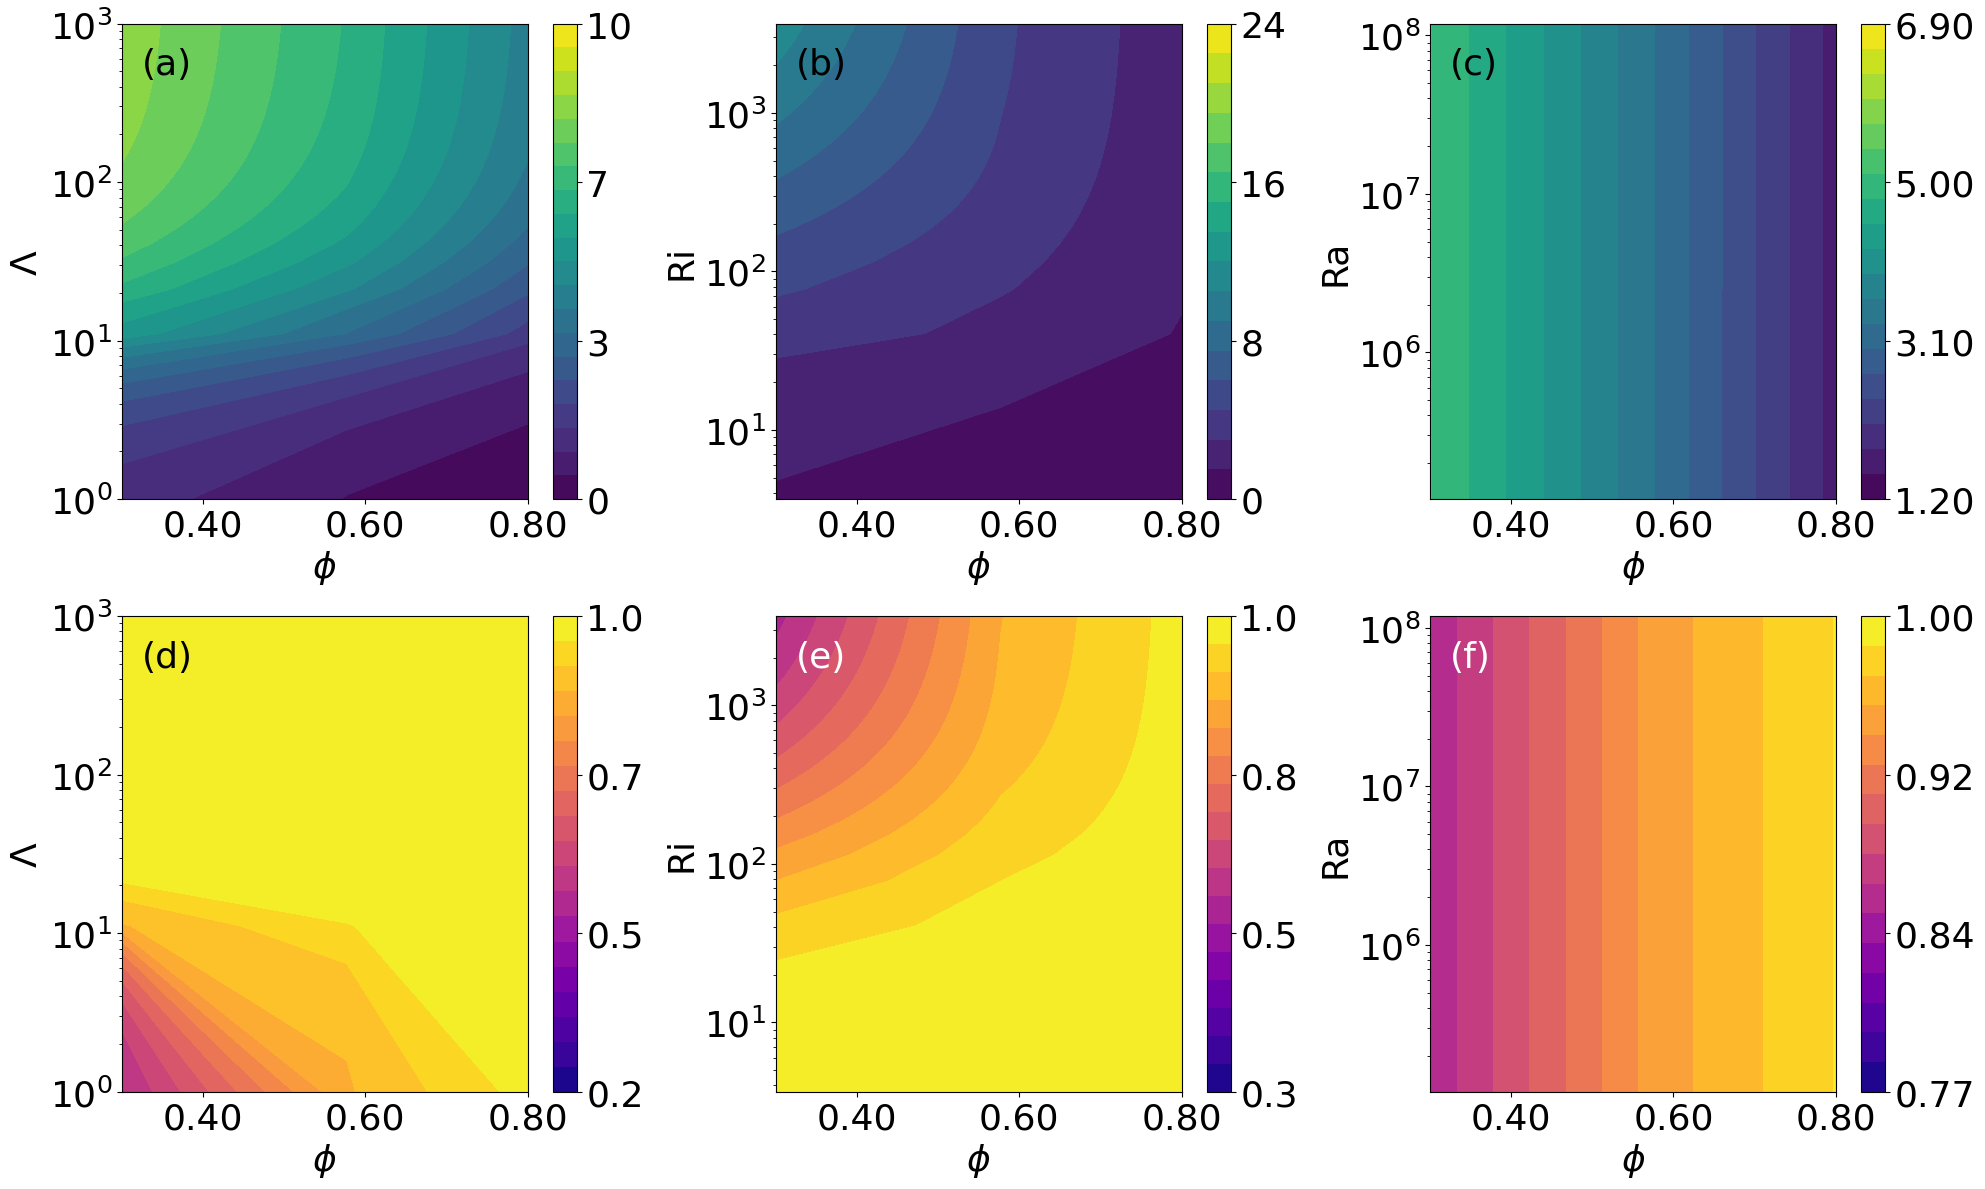

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from matplotlib.ticker import FuncFormatter, LogFormatter, LogLocator

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presion atmosferica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]


## DEFINICION DE FUNCIONES

# Calculo de parametros 
def calculate_parameters(delta_T, D, L):
    h = 1.42 * (delta_T/L)**(1/4)
    phi = 1 / (beta * delta_T)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T / h**2
    Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h)
    LAMBDA = L/D
    return phi, Ri, Ra, LAMBDA, h

# Calculo de la velocidad por Newton-Raphson
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v, max_iter  # Devuelve el ultimo valor y el numero maximo de iteraciones si no converge

# Calculo de la distribucion espacial de theta_star
def theta_estrella(eta, LAMBDA, v_e):
    a = LAMBDA / v_e
    return 1 - np.exp(-a * eta)

#funciones para el calculo de los isocontornos
# Define una funcion exponencial de seguridad
def safe_exp(x):
    try:
        return np.exp(x) if x < 700 else np.inf
    except:
        return np.inf

# Calculo de velocidad por Newton-Raphson adaptada para evitar divergencias
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - safe_exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + LAMBDA/v)*safe_exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        try:
            v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
            if abs(v_new - v) < tol:
                return v_new
            v = v_new
        except:
            return np.nan
    return np.nan  # Devuelve NaN si no converge

# Calculo de theta(v)
def calculate_theta(LAMBDA, v):
    return 1 - safe_exp(-LAMBDA/v)

# Funcion para formatear los ticks
def format_func(value, tick_number, decimals):
    return f'{value:.{decimals}f}'

def format_x_ticks(value, tick_number):
    if value < 1e-3:
        return f'{value:.1e}'  # Notacion cientifica para valores muy pequenos
    elif value < 0.1:
        return f'{value:.3f}'  # Tres decimales para valores pequenos
    else:
        return f'{value:.2f}'  # Dos decimales para otros valores

def setup_subplot(ax, im, xlabel, ylabel, letter):
    ax.set_xlabel(xlabel, fontsize=26)
    ax.set_ylabel(ylabel, fontsize=26, rotation=90)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # Ajustar el limite superior del eje y para la grafica 'd'
    if letter == 'd':
        ax.set_ylim(1e-8, 1e2)
    else:
        ax.set_ylim(1e-8, 1e8)
    
    ax.set_xlim(0.3, 0.8)
    
    vmin, vmax = im.get_clim()
    ticks = np.linspace(vmin, vmax, 4)
    
    cbar = fig.colorbar(im, ax=ax, ticks=ticks)
    cbar.ax.tick_params(labelsize=26)
    
    if letter in 'ab':
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: f'{value:.0f}'))
    elif letter in 'cf':
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 2)))
    else:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 1)))
    
    color = 'black' if letter in 'abcd' else 'white'
    ax.text(0.05, 0.95, f'({letter})', transform=ax.transAxes, 
            ha='left', va='top', fontsize=26, color=color)
   
    ax.tick_params(axis='both', which='major', labelsize=26)
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.xaxis.set_tick_params(which='both', labelsize=26)
    
    ax.figure.canvas.draw()



## REPRESENTACION DE LA EVOLUCION ESPACIAL DE theta_star + IMPRESION DE TABLA DE DATOS
# Definicion de las dimensiones de la tuberia
D = 20
L = 100

# Primero, creamos una lista para almacenar los datos de cada fila
table_data = []

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500, 1000, 5000, 10000]

# Crear la figura con un tamano especifico y espacio para la leyenda
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar y recopilar datos
for delta_T in delta_T_list:
    phi, Ri, Ra, LAMBDA, h = calculate_parameters(delta_T, D, L)
    v_0 = newton_raphson(phi, Ri, Ra, LAMBDA)
    eta = np.linspace(0, 1, 1000)
    theta = theta_estrella(eta, LAMBDA, v_0)
    theta_1 = theta_estrella(1, LAMBDA, v_0)
    T_f = delta_T * theta_1 + T_a
    ax.plot(eta, theta, linewidth=2, 
            label=f'$\Delta T$ = {delta_T:.0f}K')
    table_data.append([delta_T, v_0, theta_1, T_f-273, Ra, Ri, phi])

# Configurar los ejes y etiquetas
ax.set_xlabel(r'$\eta$', fontsize=26)
ax.set_ylabel(r'$\theta^*$', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', pad=10)

# Mover la leyenda fuera de la grafica
ax.legend(fontsize=26, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseno para que la leyenda no se superponga
plt.tight_layout()

# Mostrar la grafica
plt.show()

# Ahora generamos el codigo LaTeX para la tabla
latex_table = r"\begin{table}[h]" + "\n"
latex_table += r"\centering" + "\n"
latex_table += r"\begin{tabular}{|c|c|c|c|c|c|c|}" + "\n"
latex_table += r"\hline" + "\n"
latex_table += r"$\Delta T$ (K) & $v_e$ & $\theta^*(\eta=1)$ & $T_f$ ($^\circ$C) & Ra & Ri & $\phi$ \\" + "\n"
latex_table += r"\hline" + "\n"

# Anadimos los datos a la tabla
for row in table_data:
    latex_table += f"{row[0]:.0f} & {row[1]:.2f} & {row[2]:.4f} & {row[3]:.2f} & {row[4]:.2e} & {row[5]:.2e} & {row[6]:.4f} \\\\" + "\n"
    latex_table += r"\hline" + "\n"

latex_table += r"\end{tabular}" + "\n"
latex_table += r"\caption{Valores relevantes para diferentes $\Delta T$}" + "\n"
latex_table += r"\label{tab:resultados}" + "\n"
latex_table += r"\end{table}"

# Imprimimos el codigo LaTeX
print(latex_table)

## CALCULO DE ISOCONTORNOS

# Definimos extremos de los rangos de valores de phi, Ri, Ra, Lambda
temperaturas = np.array([10, 10000])
LAMBDA_extremos = [1, 10**3]
phi_extremos = 1/ (beta * temperaturas)
Ri_extremos = 2 * rho_0**2 * g * beta * L * Cp**2 * temperaturas /  h**2 
Ra_extremos = rho_0**2 * g * beta * Cp * D**2 * temperaturas / (16 * nu * h) 

resolucion = 100 # resolucion de las graficas

# Definir los rangos para los ejes
phi_range = np.linspace(phi_extremos[0], phi_extremos[1], resolucion)
LAMBDA_range = np.linspace(LAMBDA_extremos[0], LAMBDA_extremos[1], resolucion)
Ri_range = np.linspace(Ri_extremos[0], Ri_extremos[1], resolucion)
Ra_range = np.linspace(Ra_extremos[0], Ra_extremos[1], resolucion)

# Definir valores constantes para la representacion
LAMBDA_cte = 10
Ri_cte = 10**2
Ra_cte = 10**6

# Inciar matrices
v_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
v_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))
v_Ra_phi = np.zeros((len(phi_range), len(Ra_range)))

theta_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
theta_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))
theta_Ra_phi = np.zeros((len(phi_range), len(Ra_range)))

# Rellena las matrices
for i in range(resolucion):
    for j in range(resolucion):
        try:
            # LAMBDA vs phi 
            v = newton_raphson(phi_range[j], Ri_cte, Ra_cte, LAMBDA_range[i])
            v_lambda_phi[i, j] = v
            theta_lambda_phi[i, j] = calculate_theta(LAMBDA_range[i], v)
            
            # Ri vs phi
            v = newton_raphson(phi_range[j], Ri_range[i], Ra_cte, LAMBDA_cte)
            v_Ri_phi[i, j] = v
            theta_Ri_phi[i, j] = calculate_theta(LAMBDA_cte, v)
            
            # Ra vs phi 
            v = newton_raphson(phi_range[j], Ri_cte, Ra_range[i], LAMBDA_cte)
            v_Ra_phi[i, j] = v
            theta_Ra_phi[i, j] = calculate_theta(LAMBDA_cte, v)
        except:
            print(f"Error at i={i}, j={j}")
            v_lambda_phi[i, j] = np.nan
            theta_lambda_phi[i, j] = np.nan
            v_Ri_phi[i, j] = np.nan
            theta_Ri_phi[i, j] = np.nan
            v_Ra_phi[i, j] = np.nan
            theta_Ra_phi[i, j] = np.nan

print("Matrices created successfully.")

## REPRESENTACION
i
# Crear una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Lista de parametros para cada subplot
subplot_params = [
    (v_lambda_phi, r'$\phi$', r'$\Lambda$', LAMBDA_range),
    (v_Ri_phi, r'$\phi$', 'Ri', Ri_range),
    (v_Ra_phi, r'$\phi$', 'Ra', Ra_range),
    (theta_lambda_phi, r'$\phi$', r'$\Lambda$', LAMBDA_range),
    (theta_Ri_phi, r'$\phi$', 'Ri', Ri_range),
    (theta_Ra_phi, r'$\phi$', 'Ra', Ra_range)
]

# Crear subplots
for i, (data, xlabel, ylabel, y_range) in enumerate(subplot_params):
    row = i // 3
    col = i % 3
    letter = chr(97 + i)  # 'a' to 'f'
    cmap = 'viridis' if i < 3 else 'plasma'
    
    im = axs[row, col].contourf(phi_range, y_range, data, levels=20, cmap=cmap)
    setup_subplot(axs[row, col], im, xlabel, ylabel, letter)
    axs[row, col].set_ylim(min(y_range), max(y_range))

# Asegurarse de que los cambios se apliquen a todos los subplots
for ax in axs.flat:
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.xaxis.set_tick_params(which='both', labelsize=26)
    ax.figure.canvas.draw()

plt.tight_layout()
plt.show()


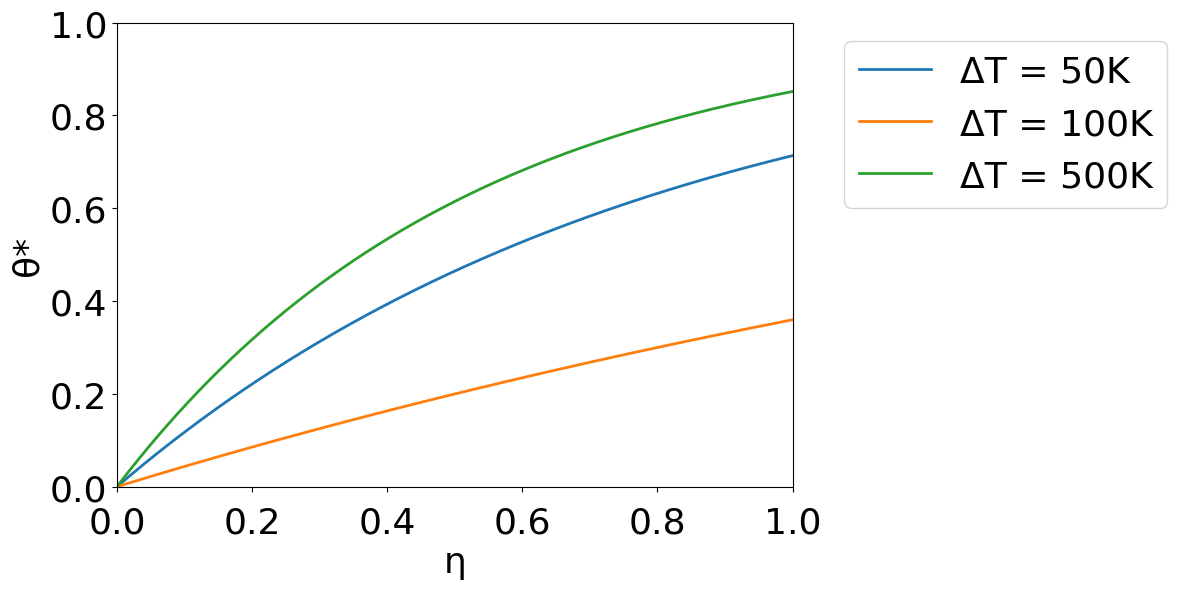

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
$\Delta T$ (K) & $v_e$ & $\theta^*(\eta=1)$ & $T_f$ ($^\circ$C) & Ra & Ri & $\phi$ \\
\hline
50 & 4.00 & 0.7132 & 55.66 & 2.23e+06 & 2.58e+02 & 5.4496 \\
\hline
100 & 11.22 & 0.3596 & 55.96 & 3.75e+06 & 3.65e+02 & 2.7248 \\
\hline
500 & 2.62 & 0.8514 & 445.68 & 1.25e+07 & 8.17e+02 & 0.5450 \\
\hline
\end{tabular}
\caption{Valores relevantes para diferentes $\Delta T$}
\label{tab:resultados}
\end{table}


In [11]:
def calculate_parameters(delta_T):
    T_w = T_a + delta_T
    h = 1.42 * (delta_T/L)**(1/4)
    phi = 1 / (beta * delta_T)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T / h**2
    Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h)
    LAMBDA = L/D
    return phi, Ri, Ra, LAMBDA, h

def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v, max_iter  # Devuelve el último valor y el número máximo de iteraciones si no converge


def theta_estrella(eta, LAMBDA, v_e):
    a = LAMBDA / v_e
    return 1 - np.exp(-a * eta)

# Primero, creamos una lista para almacenar los datos de cada fila
table_data = []

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500]

# Crear la figura con un tamaño específico y espacio para la leyenda
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar y recopilar datos
for delta_T in delta_T_list:
    phi, Ri, Ra, LAMBDA, h = calculate_parameters(delta_T)
    v_0, _ = newton_raphson(phi, Ri, Ra, LAMBDA)
    eta = np.linspace(0, 1, 1000)
    theta = theta_estrella(eta, LAMBDA, v_0)
    theta_1 = theta_estrella(1, LAMBDA, v_0)
    T_f = delta_T * theta_1 + T_a
    ax.plot(eta, theta, linewidth=2, 
            label=f'ΔT = {delta_T:.0f}K')
    table_data.append([delta_T, v_0, theta_1, T_f-273, Ra, Ri, phi])

# Configurar los ejes y etiquetas
ax.set_xlabel('η', fontsize=26)
ax.set_ylabel('θ*', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', pad=10)

# Mover la leyenda fuera de la gráfica
ax.legend(fontsize=26, bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que la leyenda no se superponga
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Ahora generamos el código LaTeX para la tabla
latex_table = r"\begin{table}[h]" + "\n"
latex_table += r"\centering" + "\n"
latex_table += r"\begin{tabular}{|c|c|c|c|c|c|c|}" + "\n"
latex_table += r"\hline" + "\n"
latex_table += r"$\Delta T$ (K) & $v_e$ & $\theta^*(\eta=1)$ & $T_f$ ($^\circ$C) & Ra & Ri & $\phi$ \\" + "\n"
latex_table += r"\hline" + "\n"

# Añadimos los datos a la tabla
for row in table_data:
    latex_table += f"{row[0]:.0f} & {row[1]:.2f} & {row[2]:.4f} & {row[3]:.2f} & {row[4]:.2e} & {row[5]:.2e} & {row[6]:.4f} \\\\" + "\n"
    latex_table += r"\hline" + "\n"

latex_table += r"\end{tabular}" + "\n"
latex_table += r"\caption{Valores relevantes para diferentes $\Delta T$}" + "\n"
latex_table += r"\label{tab:resultados}" + "\n"
latex_table += r"\end{table}"

# Imprimimos el código LaTeX
print(latex_table)



LAMBDA [1, 1000]
phi [27.2479564   0.27247956]
Ri [  16.3388494  1633.88493966]
Ra [  250602.67661732 25060267.66173234]


/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1997/2827886268.py:39: RuntimeWarning: invalid value encountered in scalar divide
  v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)


Matrices created successfully.


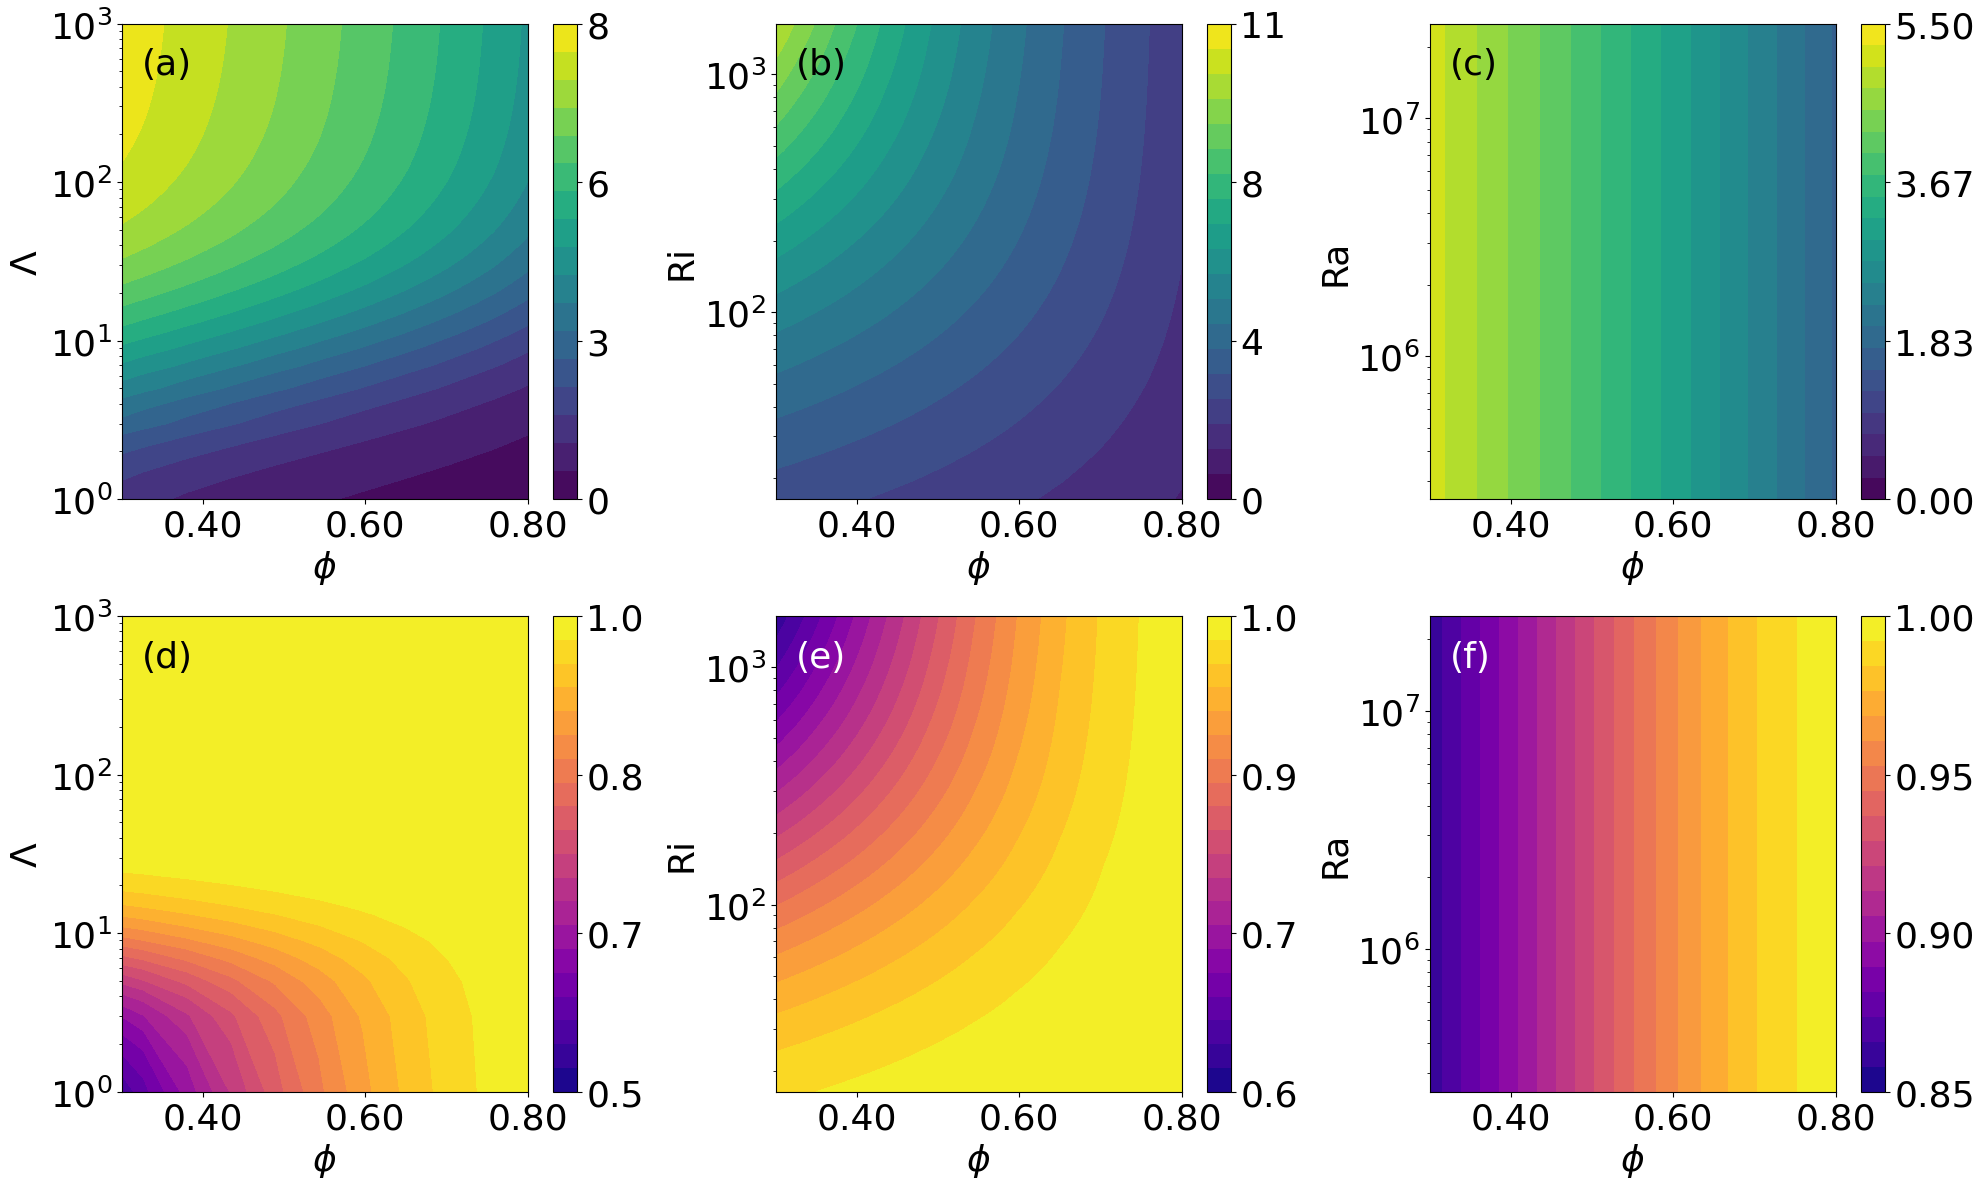

In [13]:
temperaturas = np.array([10, 1000])
LAMBDA_extremos = [1, 10**3]
phi_extremos = 1/ (beta * temperaturas)
Ri_extremos = 2 * rho_0**2 * g * beta * L * Cp**2 * temperaturas /  h**2 
Ra_extremos = rho_0**2 * g * beta * Cp * D**2 * temperaturas / (16 * nu * h) 

print('LAMBDA ' + str(LAMBDA_extremos) + '\nphi ' + str(phi_extremos) + '\nRi ' + str(Ri_extremos) + '\nRa ' + str(Ra_extremos))

resolucion = 500

# Definir los rangos para los ejes
phi_range = np.linspace(phi_extremos[0], phi_extremos[1], resolucion)
LAMBDA_range = np.linspace(LAMBDA_extremos[0], LAMBDA_extremos[1], resolucion)
Ri_range = np.linspace(Ri_extremos[0], Ri_extremos[1], resolucion)
Ra_range = np.linspace(Ra_extremos[0], Ra_extremos[1], resolucion)

LAMBDA_cte = 10
Ri_cte = 10**2
Ra_cte = 10**6

# Define a safe exponential function
def safe_exp(x):
    try:
        return np.exp(x) if x < 700 else np.inf
    except:
        return np.inf

# Define functions
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - safe_exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + LAMBDA/v)*safe_exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        try:
            v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
            if abs(v_new - v) < tol:
                return v_new
            v = v_new
        except:
            return np.nan
    return np.nan  # Return NaN if it doesn't converge

def calculate_theta(LAMBDA, v):
    return 1 - safe_exp(-LAMBDA/v)

# Initialize matrices
v_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
v_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))
v_Ra_phi = np.zeros((len(phi_range), len(Ra_range)))

theta_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
theta_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))
theta_Ra_phi = np.zeros((len(phi_range), len(Ra_range)))

# Fill matrices
for i in range(resolucion):
    for j in range(resolucion):
        try:
            # LAMBDA and phi variables
            v = newton_raphson(phi_range[j], Ri_cte, Ra_cte, LAMBDA_range[i])
            v_lambda_phi[i, j] = v
            theta_lambda_phi[i, j] = calculate_theta(LAMBDA_range[i], v)
            
            # Ri and phi variables
            v = newton_raphson(phi_range[j], Ri_range[i], Ra_cte, LAMBDA_cte)
            v_Ri_phi[i, j] = v
            theta_Ri_phi[i, j] = calculate_theta(LAMBDA_cte, v)
            
            # Ra and phi variables
            v = newton_raphson(phi_range[j], Ri_cte, Ra_range[i], LAMBDA_cte)
            v_Ra_phi[i, j] = v
            theta_Ra_phi[i, j] = calculate_theta(LAMBDA_cte, v)
        except:
            print(f"Error at i={i}, j={j}")
            v_lambda_phi[i, j] = np.nan
            theta_lambda_phi[i, j] = np.nan
            v_Ri_phi[i, j] = np.nan
            theta_Ri_phi[i, j] = np.nan
            v_Ra_phi[i, j] = np.nan
            theta_Ra_phi[i, j] = np.nan

print("Matrices created successfully.")

# Crear una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Función para formatear los ticks
def format_func(value, tick_number, decimals):
    return f'{value:.{decimals}f}'

def format_x_ticks(value, tick_number):
    if value < 1e-3:
        return f'{value:.1e}'  # Notación científica para valores muy pequeños
    elif value < 0.1:
        return f'{value:.3f}'  # Tres decimales para valores pequeños
    else:
        return f'{value:.2f}'  # Dos decimales para otros valores

def setup_subplot(ax, im, xlabel, ylabel, letter):
    ax.set_xlabel(xlabel, fontsize=26)
    ax.set_ylabel(ylabel, fontsize=26, rotation=90)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    # Ajustar el límite superior del eje y para la gráfica 'd'
    if letter == 'd':
        ax.set_ylim(1e-8, 1e2)
    else:
        ax.set_ylim(1e-8, 1e8)
    
    ax.set_xlim(0.3, 0.8)
    
    vmin, vmax = im.get_clim()
    ticks = np.linspace(vmin, vmax, 4)
    
    cbar = fig.colorbar(im, ax=ax, ticks=ticks)
    cbar.ax.tick_params(labelsize=26)
    
    if letter in 'ab':
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: f'{value:.0f}'))
    elif letter in 'cf':
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 2)))
    else:
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 1)))
    
    color = 'black' if letter in 'abcd' else 'white'
    ax.text(0.05, 0.95, f'({letter})', transform=ax.transAxes, 
            ha='left', va='top', fontsize=26, color=color)
   
    ax.tick_params(axis='both', which='major', labelsize=26)
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.xaxis.set_tick_params(which='both', labelsize=26)
    
    ax.figure.canvas.draw()


# Lista de parámetros para cada subplot
subplot_params = [
    (v_lambda_phi, r'$\phi$', r'$\Lambda$', LAMBDA_range),
    (v_Ri_phi, r'$\phi$', 'Ri', Ri_range),
    (v_Ra_phi, r'$\phi$', 'Ra', Ra_range),
    (theta_lambda_phi, r'$\phi$', r'$\Lambda$', LAMBDA_range),
    (theta_Ri_phi, r'$\phi$', 'Ri', Ri_range),
    (theta_Ra_phi, r'$\phi$', 'Ra', Ra_range)
]

# Crear subplots
for i, (data, xlabel, ylabel, y_range) in enumerate(subplot_params):
    row = i // 3
    col = i % 3
    letter = chr(97 + i)  # 'a' to 'f'
    cmap = 'viridis' if i < 3 else 'plasma'
    
    im = axs[row, col].contourf(phi_range, y_range, data, levels=20, cmap=cmap)
    setup_subplot(axs[row, col], im, xlabel, ylabel, letter)
    axs[row, col].set_ylim(min(y_range), max(y_range))

# Asegurarse de que los cambios se apliquen a todos los subplots
for ax in axs.flat:
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.xaxis.set_tick_params(which='both', labelsize=26)
    ax.figure.canvas.draw()

plt.tight_layout()
plt.show()
